### 1. Importing Libraries
Importing essential libraries such as NumPy, Pandas, Scikit-learn, TensorFlow, and Matplotlib for handling data, building models, and visualizing results.

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error, r2_score, f1_score, precision_score, recall_score
import scipy.stats as stats
from sklearn.svm import SVR, SVC
from scipy.stats import f_oneway, kruskal
from sklearn.feature_selection import SelectFromModel

### 2. Loading and Preprocessing Data
The dataset is loaded using Pandas, and preprocessing steps such as handling missing values, normalizing features, and encoding categorical variables are applied.
The attached files *(oasis_cross-sectional-5708aa0a98d82080.xlsx)* likely belong to the <b>OASIS (Open Access Series of Imaging Studies)</b> dataset. This dataset contains MRI-based brain imaging features, demographic details, cognitive test scores, and clinical diagnosis labels.

Typical columns in OASIS Cross-Sectional Dataset:<br>

- Demographics: Age, Gender, Education Level
- Cognitive Scores: Mini-Mental State Exam (MMSE) score
- Brain MRI Features: Normalized Whole Brain Volume, Hippocampal Volume, Cortical Thickness
- Clinical Diagnosis: Alzheimer's Disease (AD) or Cognitively Normal (CN)

In [4]:
# Load the dataset
file_path = "/Users/janhavipatil/Desktop/Mini_Project/oasis_cross-sectional-5708aa0a98d82080.xlsx"  # Update with the correct file path
xls = pd.ExcelFile(file_path)

# Load the specific sheet
df = pd.read_excel(xls, sheet_name="oasis_cross-sectional")

# Check for missing values
print("Missing values before handling:\n", df.isnull().sum())

# Select only numeric columns before computing the median
numeric_cols = ["Educ", "SES", "MMSE", "CDR"]
df[numeric_cols] = df[numeric_cols].apply(lambda col: col.fillna(col.median()))

# Drop 'Delay' column
df = df.drop(columns=["Delay"])

# Verify missing values are handled
print("\nMissing values after handling:\n", df.isnull().sum())

# Save the cleaned dataset (optional)
df.to_csv("oasis_cleaned.csv", index=False)
print("\nCleaned dataset saved as 'oasis_cleaned.csv'")

Missing values before handling:
 ID         0
M/F        0
Hand       0
Age        0
Educ     201
SES      220
MMSE     201
CDR      201
eTIV       0
nWBV       0
ASF        0
Delay    416
dtype: int64

Missing values after handling:
 ID      0
M/F     0
Hand    0
Age     0
Educ    0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64

Cleaned dataset saved as 'oasis_cleaned.csv'


### 3. Handle Missing Values

In [6]:
# Load cleaned dataset
df = pd.read_csv("oasis_cleaned.csv")

# Encode target variable (CDR as Cognitive Impairment categories)
df['CDR'] = df['CDR'].map({0.0: "No Impairment", 0.5: "Mild Impairment", 1.0: "Alzheimer's"})

# Encode categorical variables
df['M/F'] = LabelEncoder().fit_transform(df['M/F'])  # Encode gender (0=F, 1=M)

# Check for missing values
print("Missing values before handling:\n", df.isnull().sum())

# Drop any remaining NaN values
df = df.dropna()

# Verify all missing values are handled
print("\nMissing values after handling:\n", df.isnull().sum())

Missing values before handling:
 ID      0
M/F     0
Hand    0
Age     0
Educ    0
SES     0
MMSE    0
CDR     2
eTIV    0
nWBV    0
ASF     0
dtype: int64

Missing values after handling:
 ID      0
M/F     0
Hand    0
Age     0
Educ    0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64


### 4. Feature Selection and Engineering
Relevant features are selected based on correlation and domain knowledge.<br>
Feature scaling is applied using MinMaxScaler or StandardScaler.<br>
The dataset is split into training and testing sets using the <b>train_test_split</b> function from Scikit-learn.<br>

In [8]:
# Select features (X) and target (y)
X = df.drop(columns=['ID', 'CDR'])  # CDR is the classification target
y = df['CDR']

# Encode categorical features
categorical_cols = X.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # Store encoder for future use

# Train-Test Split (Stratify to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Normalize numerical features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Feature Selection using L1 regularization (LASSO)
lr_fs = LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=1000)
lr_fs.fit(X_train, y_train)
sfm = SelectFromModel(lr_fs, prefit=True)

X_train = sfm.transform(X_train)
X_test = sfm.transform(X_test)

### 5. Random Forest Classifier 
To predict Alzheimer's disease progression by classifying patients into three categories:<br>

- No Impairment
- Mild Impairment
- Alzheimer’s
  
The model is optimized using <b>GridSearchCV</b>, trained on the dataset, and evaluated using Accuracy, F1-score, precision, and recall.<br> 
It also visualizes the confusion matrix and top 10 important features, ensuring reliability with cross-validation.<br>


--- Random Forest (Optimized) ---
Training Accuracy: 0.8559
Test Accuracy: 0.8046
F1 Score: 0.8241
Precision: 0.8678
Recall: 0.8046


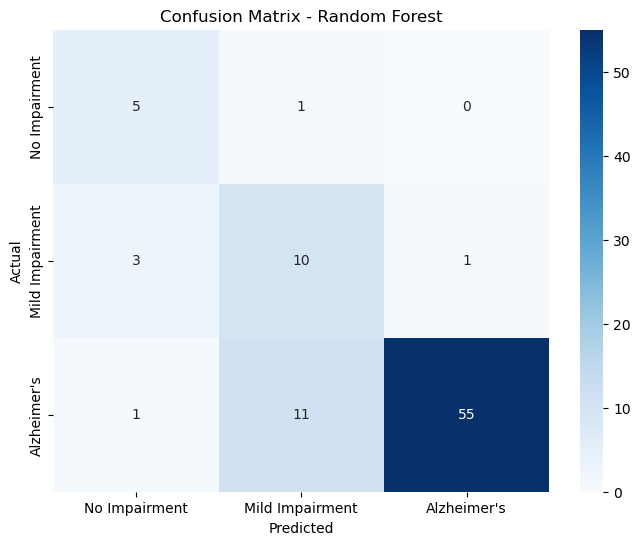

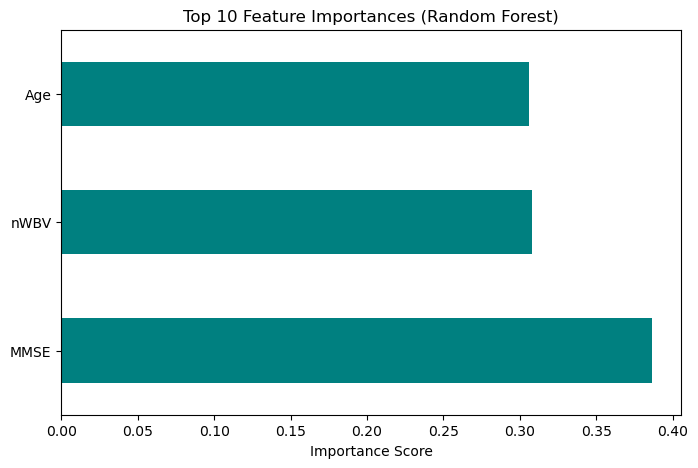

Cross-validation Accuracy (Random Forest): 0.8012


In [10]:
# ---------------- RANDOM FOREST ----------------
param_grid_rf = {
    'n_estimators': [270, 300],
    'max_depth': [20, 25],
    'min_samples_split': [20, 25],
    'min_samples_leaf': [5, 8],
    'max_features': ['sqrt'],
    'class_weight': ['balanced'],
    'bootstrap': [True],
}

rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_

# Train and Evaluate Random Forest
best_rf.fit(X_train, y_train)
y_train_pred_rf = best_rf.predict(X_train)
y_pred_rf = best_rf.predict(X_test)

# Metrics for Random Forest
acc_train_rf = accuracy_score(y_train, y_train_pred_rf)
acc_test_rf = accuracy_score(y_test, y_pred_rf)
overfitting_rf = acc_train_rf - acc_test_rf
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=1)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')

print("\n--- Random Forest (Optimized) ---")
print(f"Training Accuracy: {acc_train_rf:.4f}")
print(f"Test Accuracy: {acc_test_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")

# Define the labels for the classes
class_labels = ['No Impairment', 'Mild Impairment', "Alzheimer's"]

# Confusion Matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Plot the confusion matrix with the custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature Importance for Random Forest
selected_features = X.columns[sfm.get_support()]
feature_importances = pd.Series(best_rf.feature_importances_, index=selected_features)
feature_importances.nlargest(10).plot(kind='barh', figsize=(8, 5), color='teal')
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.show()

# Cross-validation for Random Forest
cv_scores_rf = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation Accuracy (Random Forest): {cv_scores_rf.mean():.4f}")

The model performs well with <b>80.46% Test Accuracy</b> and <b>82.41% F1-score</b>, showing reliable predictions.<br> 
High <b>Precision (86.78%)</b> means fewer false positives, while <b>Recall (80.46%)</b> indicates decent detection but could be improved to catch more actual cases. 


Actual vs Predicted (Training Data) - Random Forest - Value Counts:
Predicted        Alzheimer's  Mild Impairment  No Impairment
Actual                                                      
Alzheimer's               19                3              0
Mild Impairment           11               43              2
No Impairment              2               32            235


<Figure size 800x500 with 0 Axes>

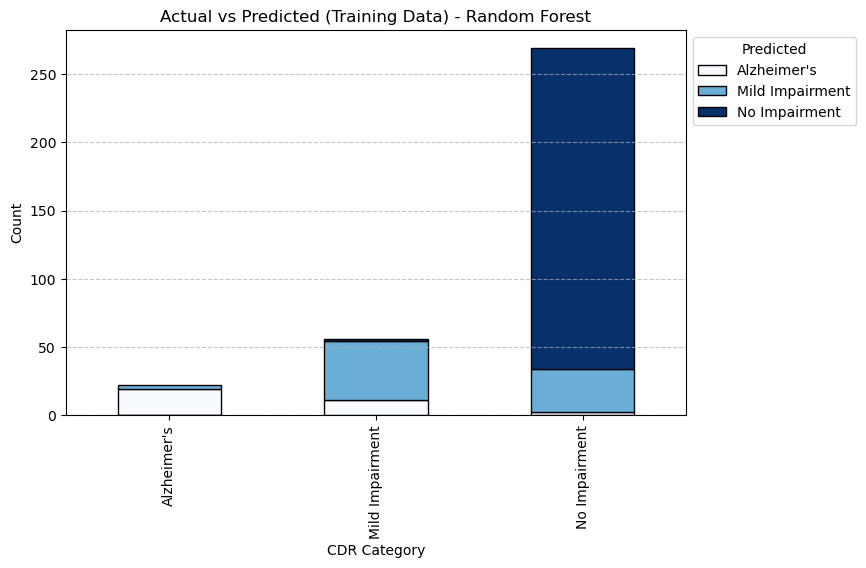


Actual vs Predicted (Testing Data) - Random Forest - Value Counts:
Predicted        Alzheimer's  Mild Impairment  No Impairment
Actual                                                      
Alzheimer's                5                1              0
Mild Impairment            3               10              1
No Impairment              1               11             55


<Figure size 800x500 with 0 Axes>

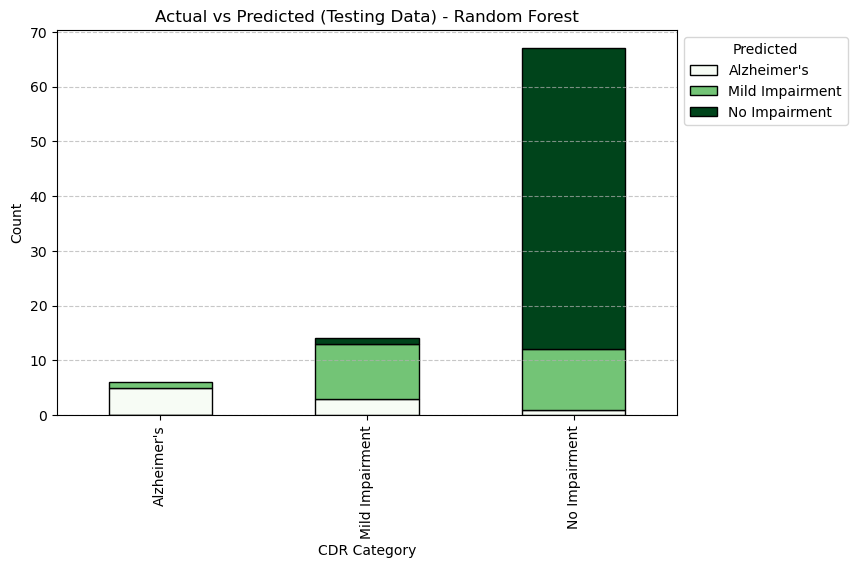

In [12]:
# Predictions Visualization
train_results_rf = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred_rf})
test_results_rf = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rf})

# Function to plot stacked bar chart with value labels
def plot_stacked_bar(data, title, palette):
    plt.figure(figsize=(8, 5))
    ct = pd.crosstab(data['Actual'], data['Predicted'])

    # Print the values in the crosstab (explicitly out of the graph)
    print(f"\n{title} - Value Counts:")
    print(ct)

    # Plot stacked bars
    ax = ct.plot(kind='bar', stacked=True, colormap=palette, figsize=(8, 5), edgecolor='black')
    plt.title(title)
    plt.xlabel("CDR Category")
    plt.ylabel("Count")
    plt.legend(title="Predicted", bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Stacked Bar Chart - Training Data for Random Forest
plot_stacked_bar(train_results_rf, "Actual vs Predicted (Training Data) - Random Forest", "Blues")

# Stacked Bar Chart - Testing Data for Random Forest
plot_stacked_bar(test_results_rf, "Actual vs Predicted (Testing Data) - Random Forest", "Greens")

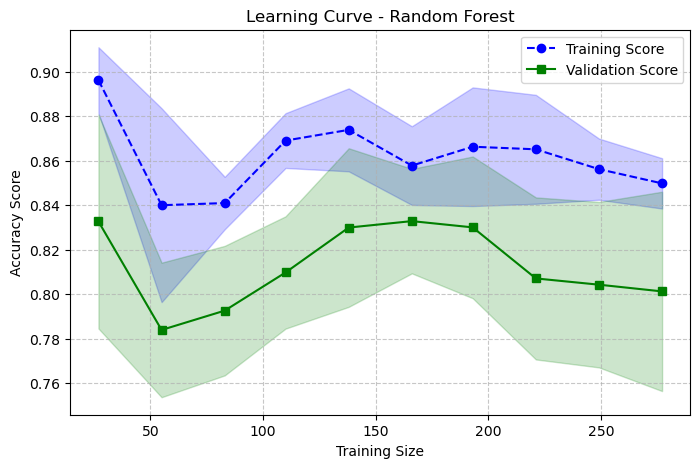

In [13]:
# Learning Curve Plot for Random Forest
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training Score", marker='o', color="blue", linestyle="--")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
    
    plt.plot(train_sizes, val_mean, label="Validation Score", marker='s', color="green")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2)

    plt.title("Learning Curve - Random Forest")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# Call the function to plot the learning curve
plot_learning_curve(best_rf, X_train, y_train)


### 6. Support Vector Machine (SVM) 

Predicts the likelihood of Alzheimer’s disease progression *(No Impairment, Mild Impairment, Alzheimer's)*.<br>
It performs *hyperparameter tuning* using GridSearchCV to find the best (regularization) and kernel type. <br>
The best model is then trained and evaluated using Accuracy, F1-score, precision, and recall.<br>
A confusion matrix visualizes classification performance.<br>


--- SVM (Optimized) ---
Training Accuracy: 0.8790
Test Accuracy: 0.8506
Overfitting Measure: 0.0284
F1 Score: 0.8489
Precision: 0.8510
Recall: 0.8506


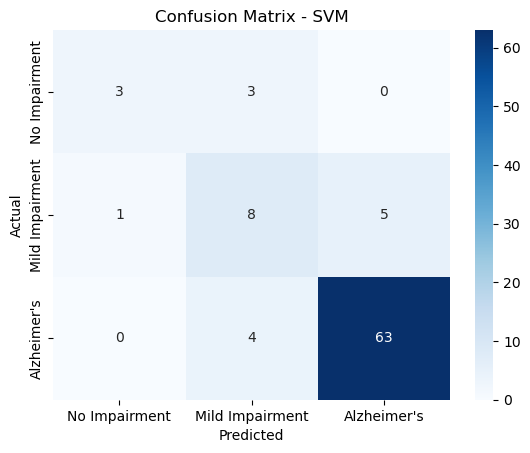

In [15]:
# ---------------- SVM ----------------
param_grid_svm = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf']
}

svm = SVC(probability=True, random_state=42)
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_

# Train and Evaluate SVM
best_svm.fit(X_train, y_train)
y_train_pred_svm = best_svm.predict(X_train)
y_pred_svm = best_svm.predict(X_test)

# Metrics for SVM
acc_train_svm = accuracy_score(y_train, y_train_pred_svm)
acc_test_svm = accuracy_score(y_test, y_pred_svm)
overfitting_svm = acc_train_svm - acc_test_svm
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
precision_svm = precision_score(y_test, y_pred_svm, average='weighted', zero_division=1)
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')

print("\n--- SVM (Optimized) ---")
print(f"Training Accuracy: {acc_train_svm:.4f}")
print(f"Test Accuracy: {acc_test_svm:.4f}")
print(f"Overfitting Measure: {overfitting_svm:.4f}")
print(f"F1 Score: {f1_svm:.4f}")
print(f"Precision: {precision_svm:.4f}")
print(f"Recall: {recall_svm:.4f}")

# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
# Define the labels for the classes
class_labels = ['No Impairment', 'Mild Impairment', "Alzheimer's"]

sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Actual vs Predicted (Training Data) - SVM - Value Counts:
Predicted        Alzheimer's  Mild Impairment  No Impairment
Actual                                                      
Alzheimer's                9               11              2
Mild Impairment            5               33             18
No Impairment              0                6            263


<Figure size 800x500 with 0 Axes>

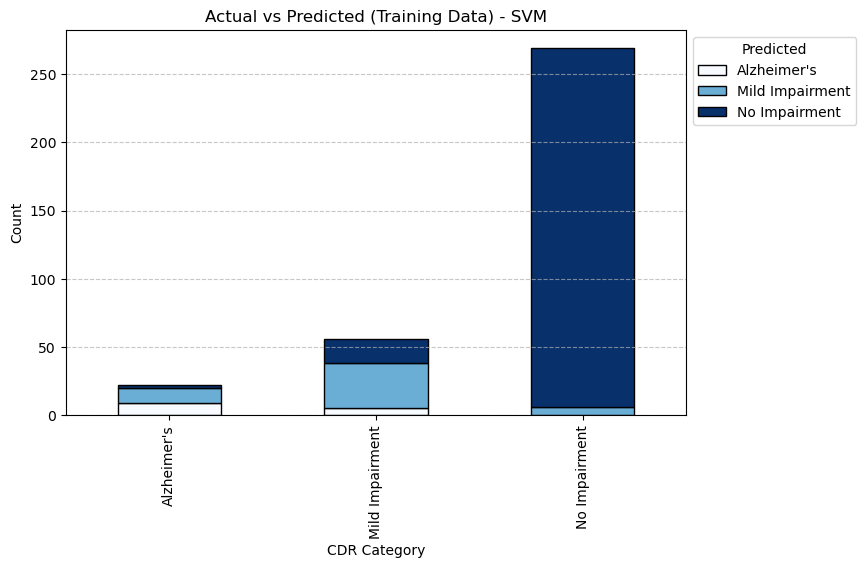


Actual vs Predicted (Testing Data) - SVM - Value Counts:
Predicted        Alzheimer's  Mild Impairment  No Impairment
Actual                                                      
Alzheimer's                3                3              0
Mild Impairment            1                8              5
No Impairment              0                4             63


<Figure size 800x500 with 0 Axes>

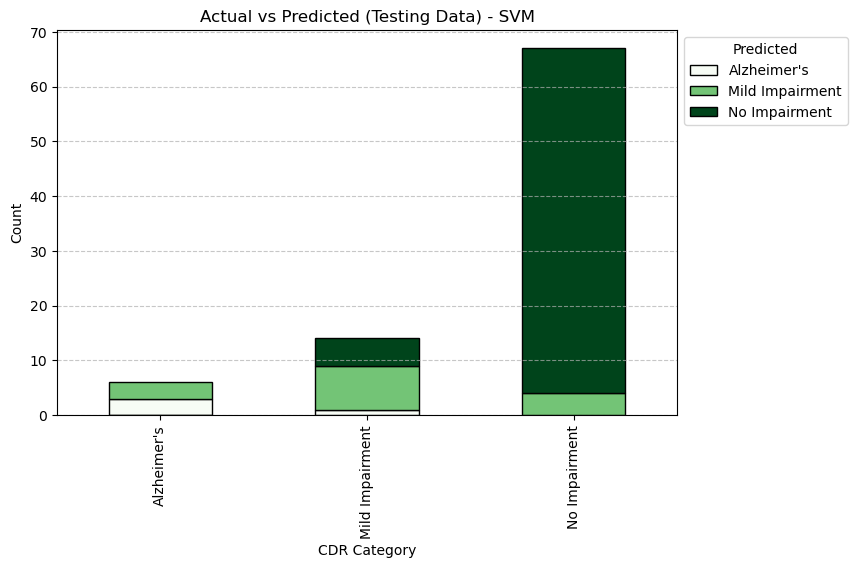

In [16]:
# Convert predictions to DataFrame for easy visualization
train_results_svm = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred_svm})
test_results_svm = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_svm})

# Function to plot stacked bar chart and print the values explicitly
def plot_stacked_bar(data, title, palette):
    plt.figure(figsize=(8, 5))
    ct = pd.crosstab(data['Actual'], data['Predicted'])

    # Print the crosstab values explicitly (out of the graph)
    print(f"\n{title} - Value Counts:")
    print(ct)

    # Plot stacked bars
    ax = ct.plot(kind='bar', stacked=True, colormap=palette, figsize=(8, 5), edgecolor='black')

    plt.title(title)
    plt.xlabel("CDR Category")
    plt.ylabel("Count")
    plt.legend(title="Predicted", bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Stacked Bar Chart - Training Data
plot_stacked_bar(train_results_svm, "Actual vs Predicted (Training Data) - SVM", "Blues")

# Stacked Bar Chart - Testing Data
plot_stacked_bar(test_results_svm, "Actual vs Predicted (Testing Data) - SVM", "Greens")

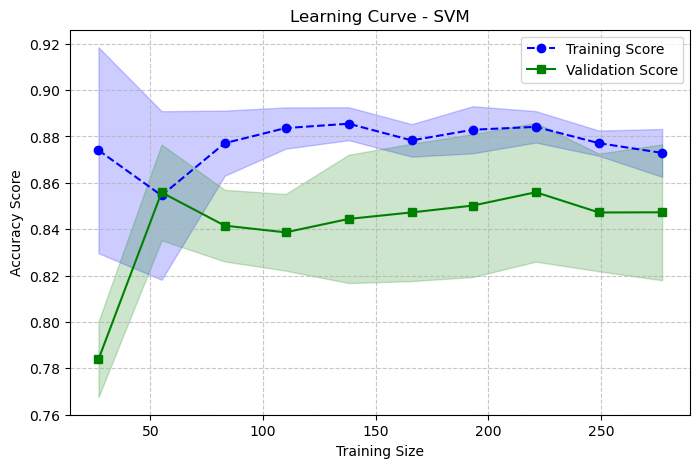

In [17]:
# Learning Curve Plot for SVM
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training Score", marker='o', color="blue", linestyle="--")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
    
    plt.plot(train_sizes, val_mean, label="Validation Score", marker='s', color="green")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2)

    plt.title("Learning Curve - SVM")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# Call the function to plot the learning curve
plot_learning_curve(best_svm, X_train, y_train)


### 7. Logistic Regression
Predicts cognitive impairment levels (No Impairment, Mild Impairment, Alzheimer’s).<br>
- Hyperparameter Tuning: Uses GridSearchCV to find the best model settings.<br>
- Training & Prediction: Best model is trained on the training data and used to predict on both training and test sets.<br>
- Evaluation Metrics: Accuracy, F1 Score, Precision, Recall, and Overfitting Measure.<br>
- Confusion Matrix: Visualizes model’s performance across classes (True/False Positives/Negatives).<br>


--- Logistic Regression (Optimized) ---
Training Accuracy: 0.8559
Test Accuracy: 0.8391
Overfitting Measure: 0.0168
F1 Score: 0.8338
Precision: 0.8526
Recall: 0.8391


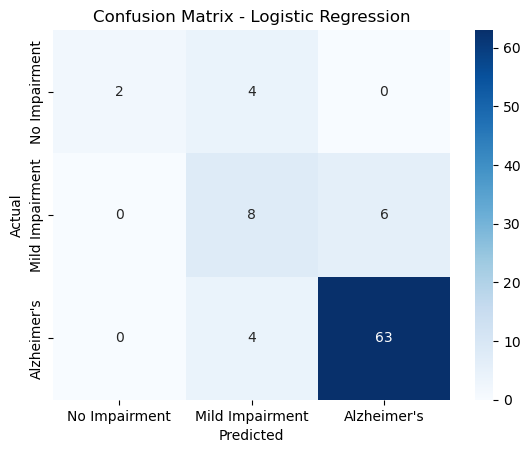

In [19]:
# ---------------- LOGISTIC REGRESSION ----------------
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['saga'],
    'penalty': ['l2']
}

lr = LogisticRegression(max_iter=1000, random_state=42)
grid_search_lr = GridSearchCV(lr, param_grid_lr, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_lr.fit(X_train, y_train)
best_lr = grid_search_lr.best_estimator_

# Train and Evaluate Logistic Regression
best_lr.fit(X_train, y_train)
y_train_pred_lr = best_lr.predict(X_train)
y_pred_lr = best_lr.predict(X_test)

# Metrics for Logistic Regression
acc_train_lr = accuracy_score(y_train, y_train_pred_lr)
acc_test_lr = accuracy_score(y_test, y_pred_lr)
overfitting_lr = acc_train_lr - acc_test_lr
f1_lr = f1_score(y_test, y_pred_lr, average='weighted')
precision_lr = precision_score(y_test, y_pred_lr, average='weighted', zero_division=1)
recall_lr = recall_score(y_test, y_pred_lr, average='weighted')

print("\n--- Logistic Regression (Optimized) ---")
print(f"Training Accuracy: {acc_train_lr:.4f}")
print(f"Test Accuracy: {acc_test_lr:.4f}")
print(f"Overfitting Measure: {overfitting_lr:.4f}")
print(f"F1 Score: {f1_lr:.4f}")
print(f"Precision: {precision_lr:.4f}")
print(f"Recall: {recall_lr:.4f}")

# Confusion Matrix for Logistic Regression
cm_lr = confusion_matrix(y_test, y_pred_lr)
# Define the labels for the classes
class_labels = ['No Impairment', 'Mild Impairment', "Alzheimer's"]
sns.heatmap(cm_lr, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Actual vs Predicted (Training Data) - Logistic Regression - Value Counts:
Predicted        Alzheimer's  Mild Impairment  No Impairment
Actual                                                      
Alzheimer's                6               15              1
Mild Impairment            6               31             19
No Impairment              0                9            260


<Figure size 800x500 with 0 Axes>

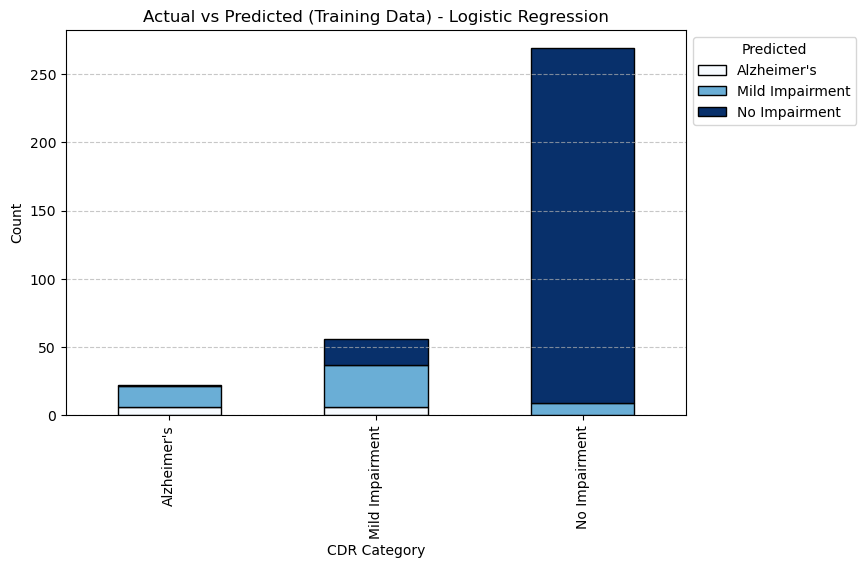


Actual vs Predicted (Testing Data) - Logistic Regression - Value Counts:
Predicted        Alzheimer's  Mild Impairment  No Impairment
Actual                                                      
Alzheimer's                2                4              0
Mild Impairment            0                8              6
No Impairment              0                4             63


<Figure size 800x500 with 0 Axes>

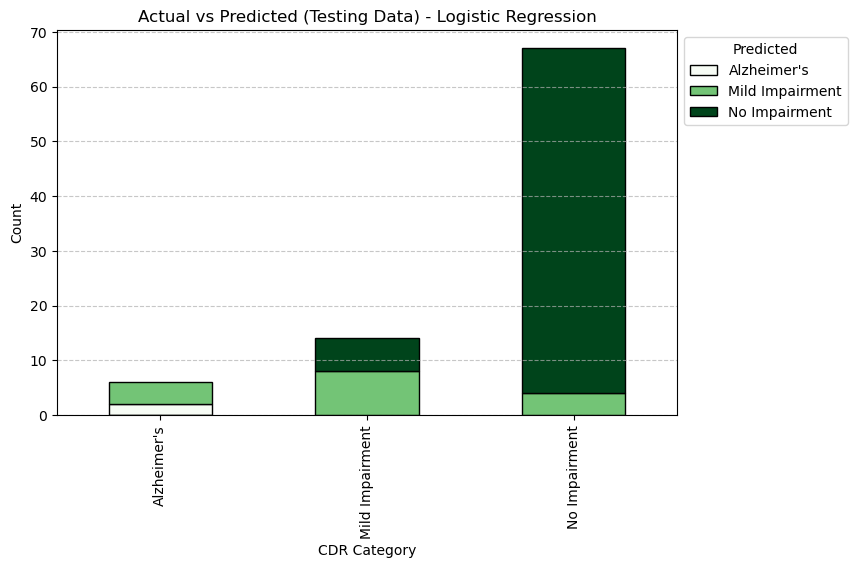

In [20]:
# Convert predictions to DataFrame for easy visualization
train_results_lr = pd.DataFrame({'Actual': y_train, 'Predicted': y_train_pred_lr})
test_results_lr = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_lr})

# Function to plot stacked bar chart and print the values
def plot_stacked_bar(data, title, palette):
    plt.figure(figsize=(8, 5))
    ct = pd.crosstab(data['Actual'], data['Predicted'])

    # Print the values in the crosstab (explicitly out of the graph)
    print(f"\n{title} - Value Counts:")
    print(ct)

    # Plot stacked bars
    ax = ct.plot(kind='bar', stacked=True, colormap=palette, figsize=(8, 5), edgecolor='black')

    plt.title(title)
    plt.xlabel("CDR Category")
    plt.ylabel("Count")
    plt.legend(title="Predicted", bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Stacked Bar Chart - Training Data
plot_stacked_bar(train_results_lr, "Actual vs Predicted (Training Data) - Logistic Regression", "Blues")

# Stacked Bar Chart - Testing Data
plot_stacked_bar(test_results_lr, "Actual vs Predicted (Testing Data) - Logistic Regression", "Greens")

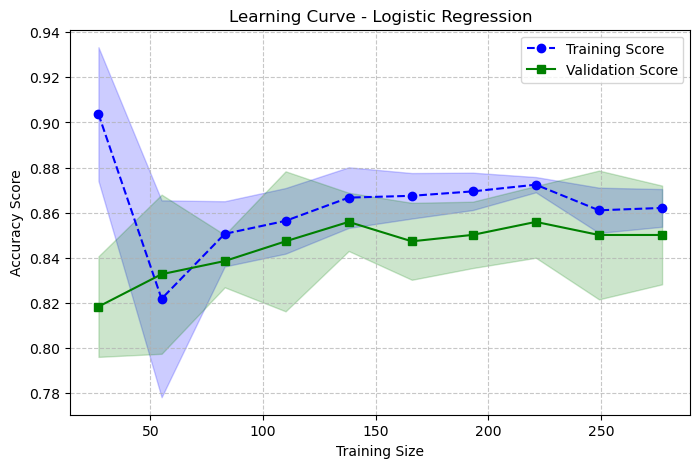

In [21]:
# Learning Curve Plot for Logistic Regression
def plot_learning_curve(model, X, y):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    # Calculate mean and standard deviation
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, label="Training Score", marker='o', color="blue", linestyle="--")
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="blue", alpha=0.2)
    
    plt.plot(train_sizes, val_mean, label="Validation Score", marker='s', color="green")
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, color="green", alpha=0.2)

    plt.title("Learning Curve - Logistic Regression")
    plt.xlabel("Training Size")
    plt.ylabel("Accuracy Score")
    plt.legend(loc="best")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# Call the function to plot the learning curve
plot_learning_curve(best_lr, X_train, y_train)

### A Regression task 
To predict the MMSE (Mini-Mental State Examination) score decline.<br>

- Target Variable: The MMSE score (y_reg) is used as the target for prediction.<br>
- Train-Test Split: The data is split into training and test sets (80%/20%).<br>
- Regression Models: Three models are used for prediction:<br>
     - Random Forest<br>
     - SVM (Support Vector Machine)<br>
     - Linear Regression<br>

- Evaluation: Each model is trained and evaluated using RMSE (Root Mean Squared Error) and R² (R-squared) to assess prediction accuracy.<br>

In [23]:
# Regression Task (Predicting MMSE Score Decline)
print("--- Regression: Predicting MMSE Score Decline ---")
y_reg = df['MMSE']  # MMSE Score decline prediction

# Train-Test Split for Regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)

# Regression Models
reg_models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVM": SVR(kernel='linear'),
    "Linear Regression": LinearRegression()
}

# Train and Evaluate Regression Models
for name, model in reg_models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train_reg, y_train_reg)
    y_pred_reg = model.predict(X_test_reg)
    
    # Regression Metrics
    rmse = mean_squared_error(y_test_reg, y_pred_reg) ** 0.5  # Manually taking the square root
    r2 = r2_score(y_test_reg, y_pred_reg)

    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")

--- Regression: Predicting MMSE Score Decline ---

--- Random Forest ---
RMSE: 0.0270
R² Score: 0.9998

--- SVM ---
RMSE: 0.0762
R² Score: 0.9983

--- Linear Regression ---
RMSE: 0.0000
R² Score: 1.0000


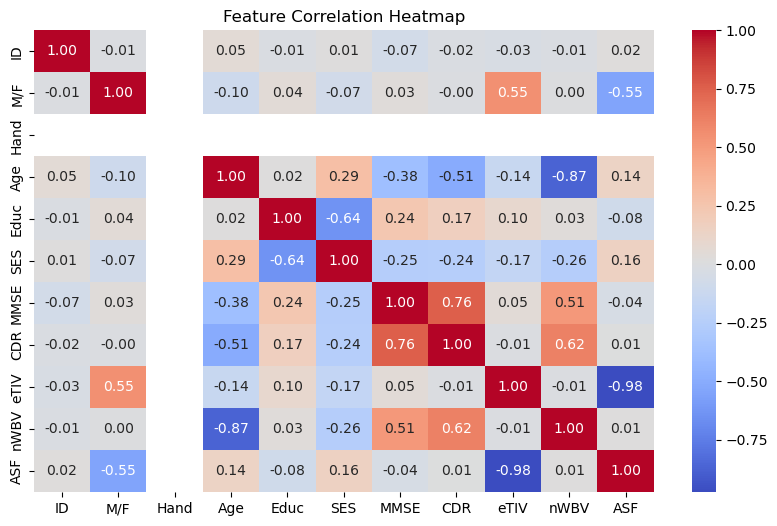

In [24]:
# Feature Correlation Heatmap
# Ensure all categorical columns are encoded
df_encoded = df.copy()
categorical_cols = df_encoded.select_dtypes(include=['object']).columns
df_encoded[categorical_cols] = df_encoded[categorical_cols].apply(LabelEncoder().fit_transform)

# Compute correlation matrix only on numeric columns
plt.figure(figsize=(10, 6))
sns.heatmap(df_encoded.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [25]:
# Perform ANOVA test on model predictions
anova_results = f_oneway(
    reg_models["Random Forest"].predict(X_test_reg),
    reg_models["SVM"].predict(X_test_reg),
    reg_models["Linear Regression"].predict(X_test_reg)
)

print("\nANOVA Test Results (Statistical Significance of Model Differences)")
print("F-Statistic:", anova_results.statistic)
print("P-Value:", anova_results.pvalue)


ANOVA Test Results (Statistical Significance of Model Differences)
F-Statistic: 0.043475984231521
P-Value: 0.9574625608124614
